In [16]:
import os
import sys
import csv
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
from torchvision.models import resnet34, ResNet34_Weights, resnet50, ResNet50_Weights
from torchvision.io import read_image
from PIL import Image
from torchsummary import summary
from torchvision.ops import sigmoid_focal_loss
from torchvision import transforms
from tqdm import tqdm

In [17]:
TRAIN_DIR = "Data/train"
TEST_DIR = "Data/test"
TRAIN_CSV_DIR = "Data/train.csv"

labels_dict = {
0:  'Nucleoplasm',
1:  'Nuclear membrane',
2:  'Nucleoli',   
3:  'Nucleoli fibrillar center',
4:  'Nuclear speckles',
5:  'Nuclear bodies',
6:  'Endoplasmic reticulum',   
7:  'Golgi apparatus',
8:  'Peroxisomes',
9:  'Endosomes',
10:  'Lysosomes',
11:  'Intermediate filaments',
12:  'Actin filaments',
13:  'Focal adhesion sites',   
14:  'Microtubules',
15:  'Microtubule ends',  
16:  'Cytokinetic bridge',   
17:  'Mitotic spindle',
18:  'Microtubule organizing center',  
19:  'Centrosome',
20:  'Lipid droplets',
21:  'Plasma membrane',   
22:  'Cell junctions', 
23:  'Mitochondria',
24:  'Aggresome',
25:  'Cytosol',
26:  'Cytoplasmic bodies',   
27:  'Rods & rings' }

numpy.ndarray

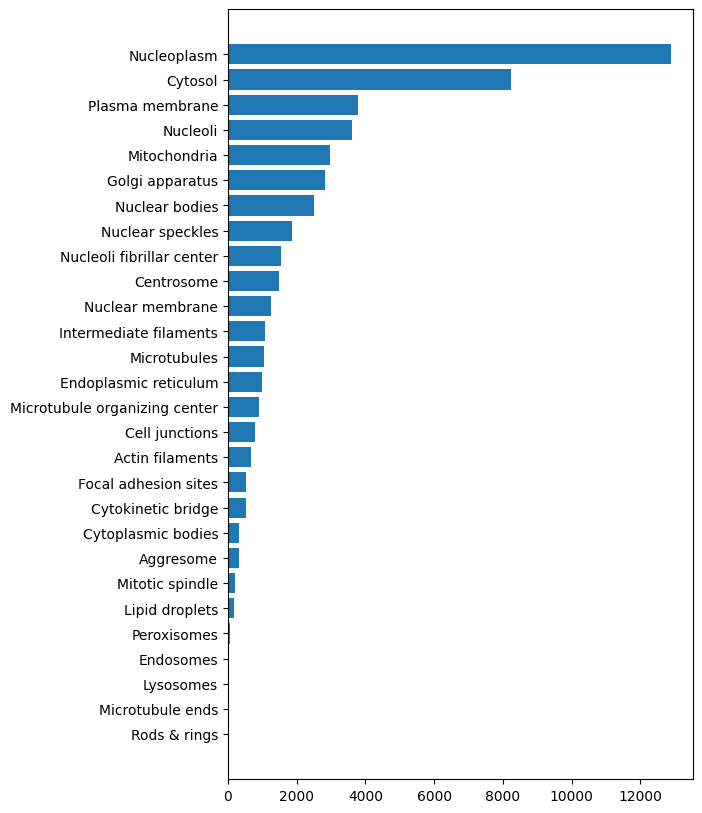

In [18]:
train_df = pd.read_csv(TRAIN_CSV_DIR)
ids = train_df["Id"].values
_labels = train_df["Target"].str.split(" ").tolist()
_labels[0] # actual training labels for each corresponding image
flat = np.array([int(e) for label in _labels for e in label])
values, counts = np.unique(flat, return_counts=True)
order = np.argsort(counts)
counts = counts[order]
values = values[order]
values = [labels_dict[e] for e in values] 
plt.figure(figsize=(6,10))
plt.barh(values, counts)
type(order)

In [19]:
NUM_LABELS = 28
labels = np.zeros((len(ids), NUM_LABELS))
for i in range(len(_labels)):
    for l in _labels[i]:
        labels[i, int(l)] = 1 # convert the training labels from integer lists to length 28 binary indicator arrays

In [20]:
torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True
torch.set_float32_matmul_precision('medium')

In [21]:
from data_loader import DataOrganizer
from custom_augmentations import RandomRotate90, FourChannelRandomJitter
# mean and SD of train set used for normalization. values computed in the next cell. 
means = [0.05273682624101639, 0.05463362857699394, 0.0804334506392479, 0.08266294747591019]
sds = [0.11251822113990784, 0.15588141977787018, 0.14967259764671326,0.149698406457901] 

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    RandomRotate90(),
    FourChannelRandomJitter(),
    transforms.Normalize(mean=means, std=sds)
    ])

val_transform = transforms.Compose([
    transforms.Normalize(mean=means, std=sds)
    ])

train_ids, val_ids, train_labels, val_labels = train_test_split(ids, labels, test_size=0.15, random_state=5432, shuffle=True)
train_set = DataOrganizer(train_ids, TRAIN_DIR, labels=train_labels, transform=train_transform)
val_set = DataOrganizer(val_ids, TRAIN_DIR, labels=val_labels, transform=val_transform)
train_dataloader = DataLoader(train_set, batch_size=8, shuffle=True, num_workers=4, pin_memory=True, persistent_workers=True)
val_dataloader = DataLoader(val_set, batch_size=8, shuffle=False, num_workers=4, pin_memory=True, persistent_workers=True) # making the train and validation data loaders to feed compiled data into model

In [22]:
model1 = resnet50(weights=ResNet50_Weights.DEFAULT) # Pretrained resnet34 model on ImageNET
model1 = model1.cuda()
#print(summary(model1, (3,224,224)))
old = model1.conv1
new = nn.Conv2d(in_channels=4, out_channels=old.out_channels, kernel_size=old.kernel_size, stride=old.stride, padding=old.padding, bias=(old.bias is not None)) # make it so the model can take 4 channel input tensors
with torch.no_grad():
    new.weight[:, :3, :, :] = old.weight
    new.weight[:, 3, :, :] = old.weight.mean(dim=1)
    if old.bias is not None:
        new.bias.data.copy_(old.bias.data)
model1.conv1 = new 
model1.fc = nn.Linear(in_features=2048, out_features=28, bias=True)
model1.to(torch.device("cuda:0"))
print("hi")

hi


In [23]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=0.25, reduction="mean"):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, logits, targets):
        BCE_loss = nn.functional.binary_cross_entropy_with_logits(logits, targets, reduction='none')
        probabilities = torch.sigmoid(logits)
        p_t = probabilities * targets + (1-probabilities) * (1 - targets)
        loss = BCE_loss * ((1 - p_t) ** self.gamma)  
        if self.alpha is not None:
            alpha_factor = self.alpha * targets + (1 - self.alpha) * (1 - targets)
            loss = alpha_factor * loss
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss
            

In [24]:
epochs=50
steps_per_epoch = len(train_dataloader)
criterion = FocalLoss() #nn.BCEWithLogitsLoss() # also test focal loss later
optimizer = optim.AdamW(model1.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, epochs=epochs, steps_per_epoch=steps_per_epoch)

In [25]:
def train(checkpoint = None):
    start = 1 # epoch
    if checkpoint:
        model1.load_state_dict(checkpoint["model_state"])
        optimizer.load_state_dict(checkpoint["optimizer_state"])
        scheduler.load_state_dict(checkpoint["scheduler_state"])
        start = checkpoint["epoch"] +1
    
    for epoch in range(start, epochs+1):
        model1.train()
        running_loss = 0.0
        train_predictions, train_actual = [], []
        train_pbar = tqdm(train_dataloader,desc=f"Epoch {epoch}/{epochs} [train]", leave=False)  
        for imgs, labels in train_pbar:
            imgs = imgs.cuda(non_blocking=True)
            labels = labels.cuda(non_blocking=True)
            optimizer.zero_grad(set_to_none=True)
            logits = model1(imgs)
            loss = criterion(logits, labels)
            probabilities = torch.sigmoid(logits).detach().cpu().numpy()
            train_predictions.append(probabilities)
            train_actual.append(labels.cpu().numpy())
                             
            loss.backward()
            optimizer.step()
            scheduler.step()
            running_loss += loss.item() * imgs.size(0)    
            train_pbar.set_postfix(
                loss = f"{loss.item():.4f}",
            )
        
        avg_train_loss = running_loss / len(train_dataloader.dataset)
        train_f1 = f1_score(np.vstack(train_actual), np.vstack(train_predictions) > 0.5, average="macro")
        
        model1.eval()
        val_predictions, val_actual = [], []
    
        val_pbar = tqdm(val_dataloader, desc=f"Epoch {epoch}/{epochs} [val]", leave=False)
    
        with torch.no_grad():
            for imgs, labels in val_pbar:
                imgs = imgs.cuda(non_blocking=True)
    
                logits = model1(imgs)
                probs  = torch.sigmoid(logits).cpu().numpy()
    
                val_predictions.append(probs)
                val_actual.append(labels.numpy())
    
        val_f1 = f1_score(
            np.vstack(val_actual),
            np.vstack(val_predictions) > 0.5,
            average="macro"
        )

        logfile = "model_checkpoints/training_log2.csv"
        try:
            logdf = pd.read_csv(logfile)
        except FileNotFoundError:
            logdf = pd.DataFrame(columns=["epoch", "train_loss", "train_f1", "val_f1"])
        new_row = {
                "epoch": epoch,
                "train_loss": avg_train_loss,
                "train_f1": train_f1,
                "val_f1": val_f1}
        logdf = pd.concat([logdf, pd.DataFrame([new_row])], ignore_index=True)
        logdf.to_csv(logfile, index=False)
    
        print(f"Epoch: {epoch:2d} │ Avg Train Loss: {avg_train_loss:.4f} | Train F1: {train_f1:.4f} │ Val F1: {val_f1:.4f}")
    
        if epoch % 2 == 0:
            path = f"model_checkpoints/res50_epoch{epoch:02d}.pth"
            torch.save({
                "epoch": epoch,
                "model_state": model1.state_dict(),
                "optimizer_state": optimizer.state_dict(),
                "scheduler_state": scheduler.state_dict(),
                "val_f1": val_f1
            }, path)
            print(f"Model saved at epoch {epoch}")


        if epoch == epochs:
            torch.save(model1, "resnet50.pth")


In [11]:
train()

KeyboardInterrupt: 

Text(0.5, 1.0, 'F1 Score vs. Epoch')

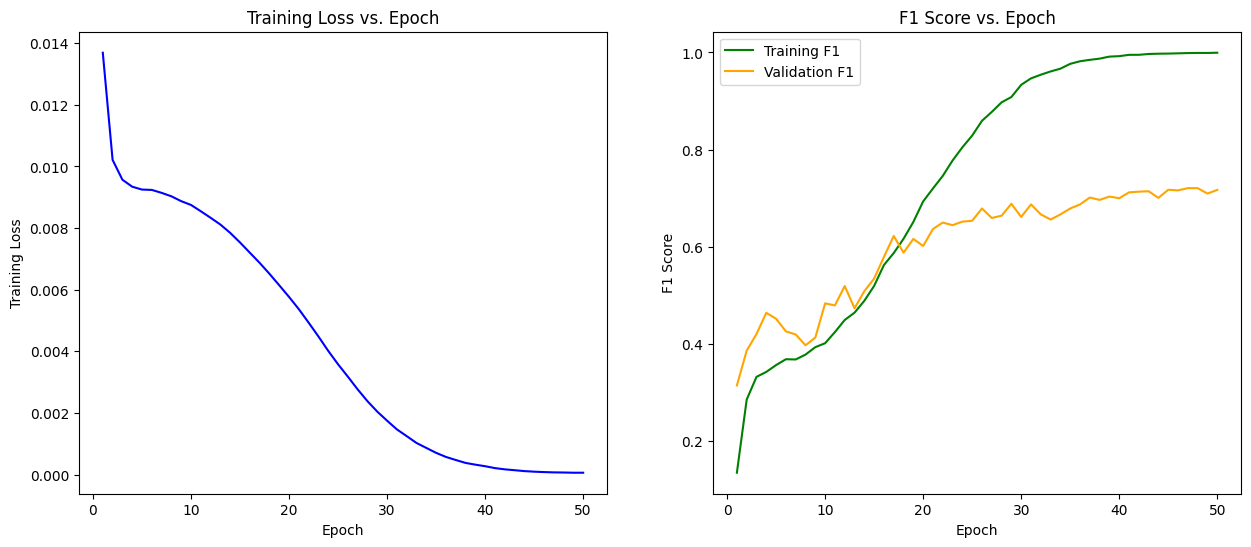

In [40]:
train_data_df = pd.read_csv("model_checkpoints/training_log2.csv")
x = train_data_df["epoch"]
y1 = train_data_df["train_loss"]
y2 = train_data_df["train_f1"]
y3 = train_data_df["val_f1"]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
axes[0].plot(x,y1, color="blue")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Training Loss")
axes[0].set_title("Training Loss vs. Epoch")
axes[1].set_title("F1 Score vs. Epoch")
axes[1].plot(x,y2, color="green", label="Training F1")
axes[1].plot(x,y3, color="orange", label="Validation F1")
axes[1].legend()
axes[1].set_ylabel("F1 Score")
axes[1].set_xlabel("Epoch")
axes[1].set_title("F1 Score vs. Epoch")

In [41]:
# threshold for inference are currently set at 0.5
# considerign the skewedness of the data, finding specific thresholds for each class may help
# model 2 is simply model 1 with all the training done. 

model2 = torch.load("resnet50.pth", map_location="cuda", weights_only=False)
model2.cuda()

model2.eval()
predictions, actual = [], []
pbar = tqdm(val_dataloader, desc=f"Inference Validation", leave=False)
with torch.no_grad():
    for imgs, labels in pbar:
        imgs = imgs.cuda(non_blocking=True)

        logits = model2(imgs)
        probs  = torch.sigmoid(logits).cpu().numpy()

        predictions.append(probs)
        actual.append(labels.numpy())
predictions = np.vstack(predictions)
actual = np.vstack(actual)

In [42]:
def show_prediction_hist(idx): # idx -> class index
    class_preds = predictions[:,idx] 
    class_true = actual[:,idx]
    true_pos = class_true == 1 # bool arr; every true indicates that the example was a true positive for label idx
    true_neg = class_true == 0
    plt.figure(figsize=(7,5))
    plt.hist(class_preds[true_pos], bins=50, label="True Positives", density=True, alpha=0.4, color="green")
    plt.hist(class_preds[true_neg], bins=50, label="True Negatives", density=True, alpha=0.4, color="orange")
    plt.axvline(x=0.5, label="Default Threshold", color="gray")
    plt.title(f"({idx}) {labels_dict[idx]} Prediction Confidence Histogram")
    plt.ylabel("Frequency")
    plt.xlabel("Model Prediction")
    plt.legend()
    plt.show()

In [43]:
def find_threshold(idx): # idx -> class index
    best_threshold = 0.5
    true = actual[:,idx]
    probs = predictions[:,idx]
    baseline = f1_score(true, probs>0.5, average="macro")
    best_score = baseline
    for x in np.linspace(0, 1, num=500):
        score = f1_score(true,probs > x,average="macro")
        if score > best_score:
            best_score = score
            best_threshold=x
    improvement = best_score-baseline
    relative_improvement = improvement/baseline
    return best_threshold, improvement, relative_improvement

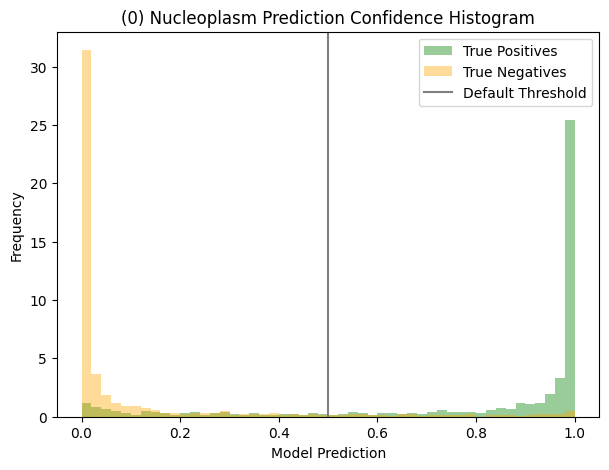

0 Nucleoplasm - New Threshold: 0.4629258517034068 | Improvement: 0.0012875895788619918 (0.001476160797315153)


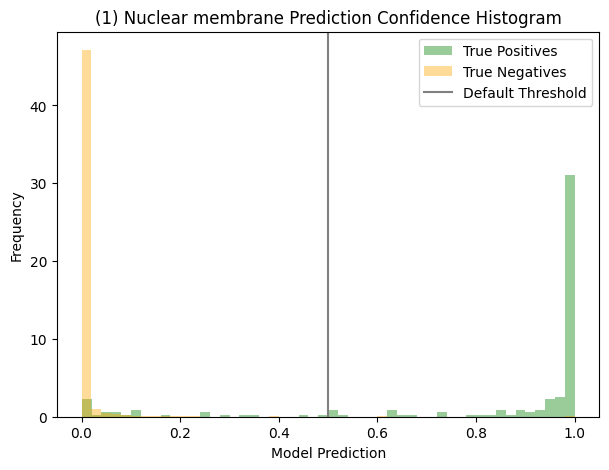

1 Nuclear membrane - New Threshold: 0.4428857715430861 | Improvement: 0.0020156606192469617 (0.0021705518526877812)


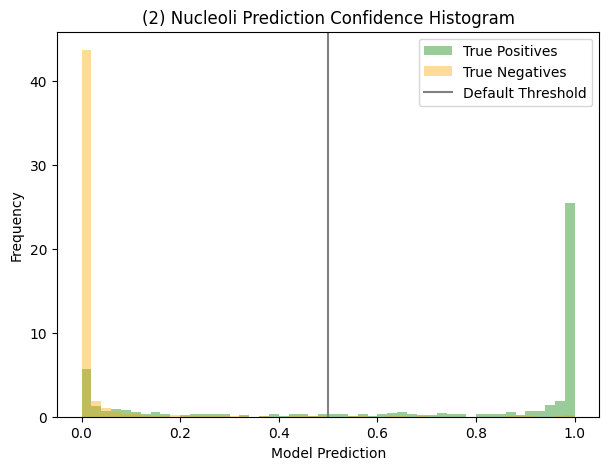

2 Nucleoli - New Threshold: 0.3887775551102204 | Improvement: 0.002233697309592886 (0.00254641431362276)


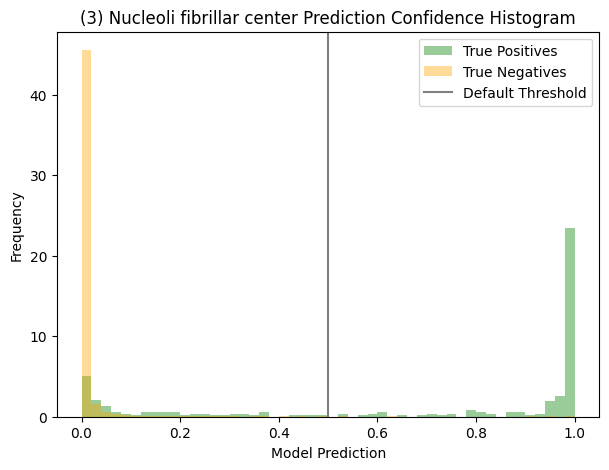

3 Nucleoli fibrillar center - New Threshold: 0.5210420841683366 | Improvement: 0.0025204264756268913 (0.0029167683267286152)


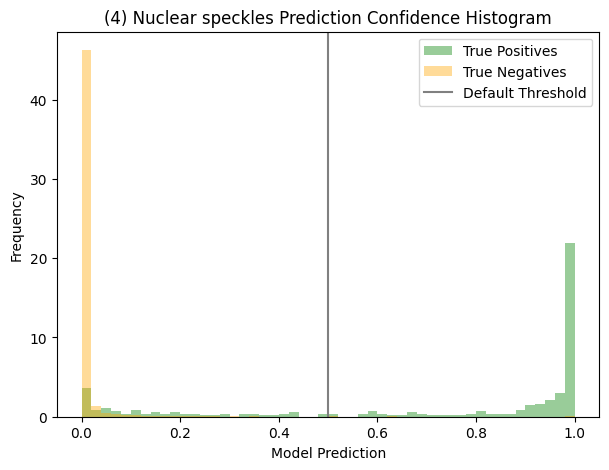

4 Nuclear speckles - New Threshold: 0.39078156312625245 | Improvement: 0.004676418903222124 (0.005244601121583827)


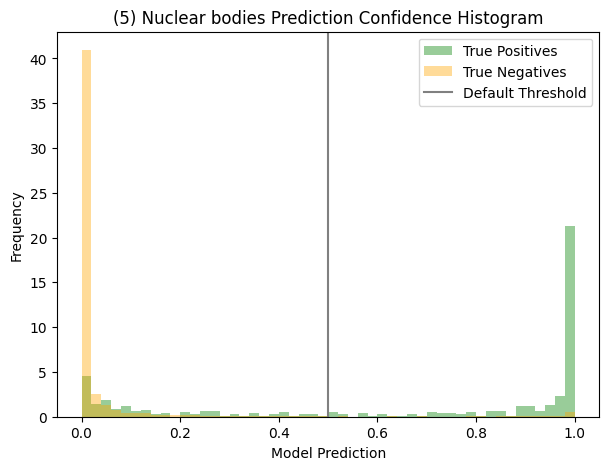

5 Nuclear bodies - New Threshold: 0.5 | Improvement: 0.0 (0.0)


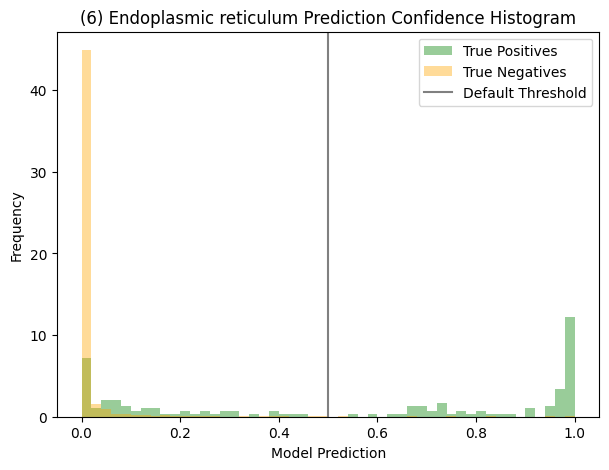

6 Endoplasmic reticulum - New Threshold: 0.625250501002004 | Improvement: 0.00502904101383872 (0.006388703128049508)


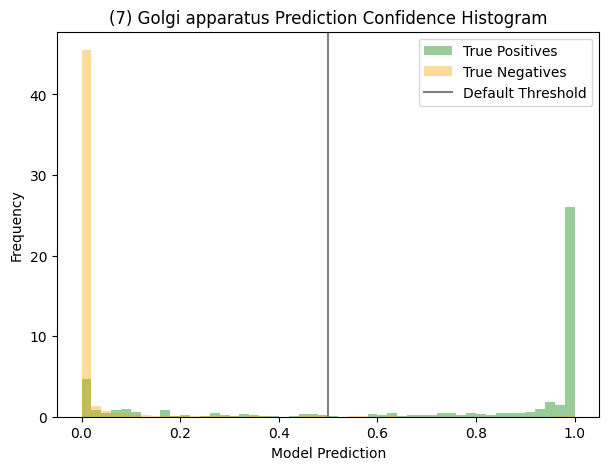

7 Golgi apparatus - New Threshold: 0.5791583166332664 | Improvement: 0.004108709750826556 (0.0045763820558140985)


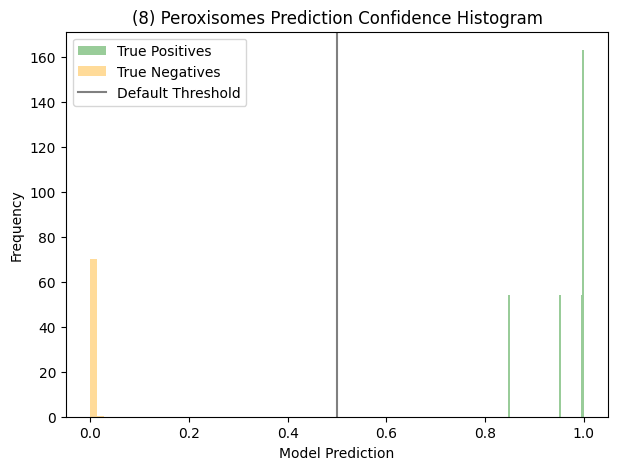

8 Peroxisomes - New Threshold: 0.7094188376753506 | Improvement: 0.038515249923564365 (0.040058097562652446)


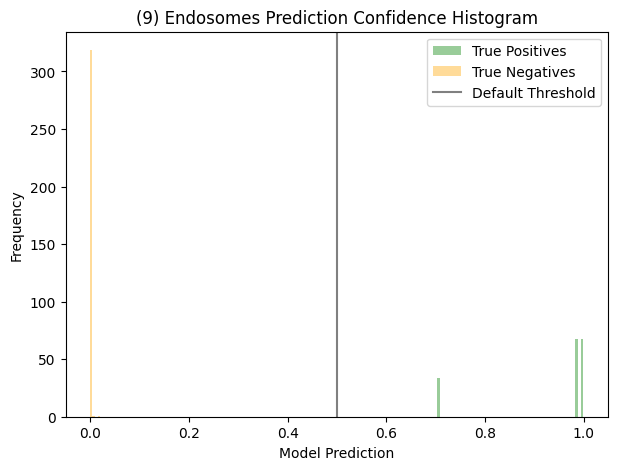

9 Endosomes - New Threshold: 0.5 | Improvement: 0.0 (0.0)


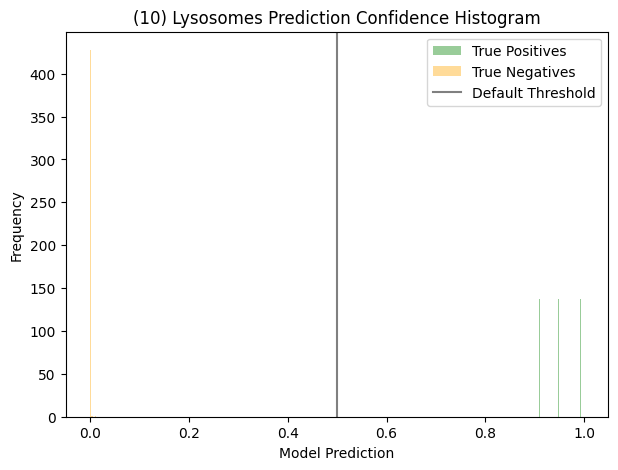

10 Lysosomes - New Threshold: 0.5 | Improvement: 0.0 (0.0)


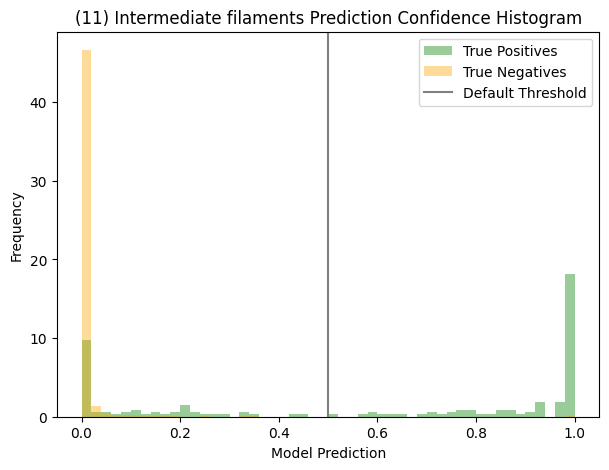

11 Intermediate filaments - New Threshold: 0.19238476953907813 | Improvement: 0.0015414408623846132 (0.0018117387962562062)


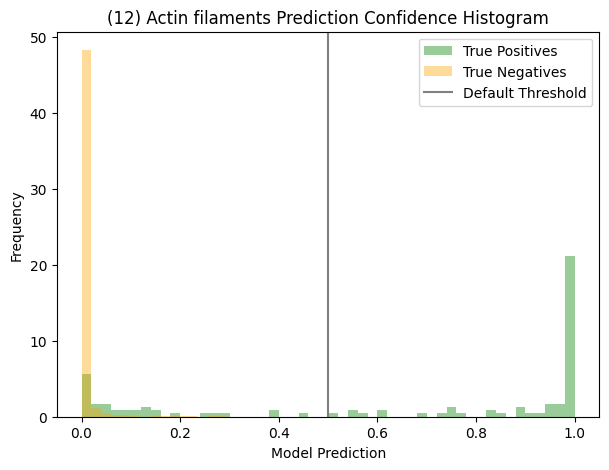

12 Actin filaments - New Threshold: 0.5 | Improvement: 0.0 (0.0)


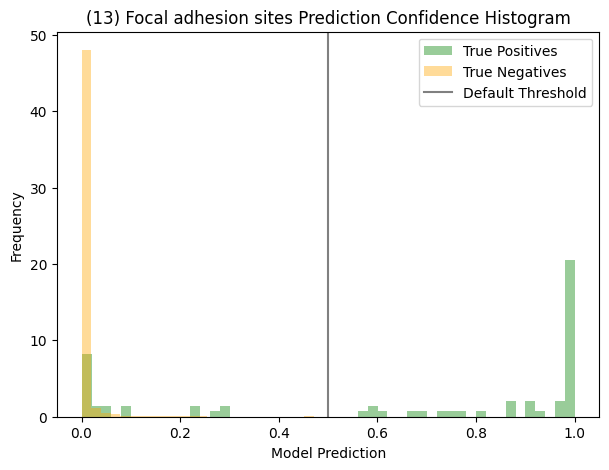

13 Focal adhesion sites - New Threshold: 0.5350701402805611 | Improvement: 0.010722872777859105 (0.012541889738755934)


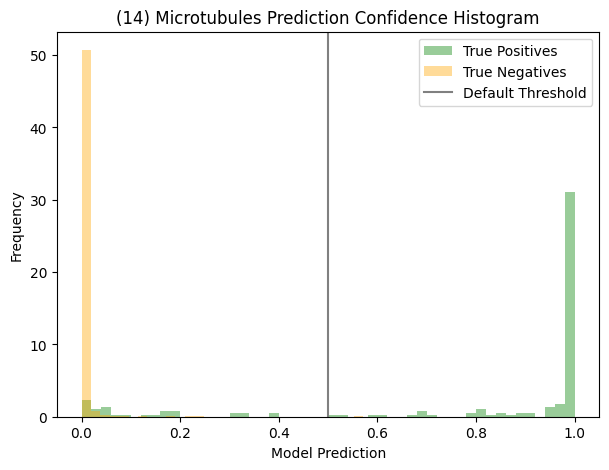

14 Microtubules - New Threshold: 0.5811623246492985 | Improvement: 0.004761112535105694 (0.005112396679689876)


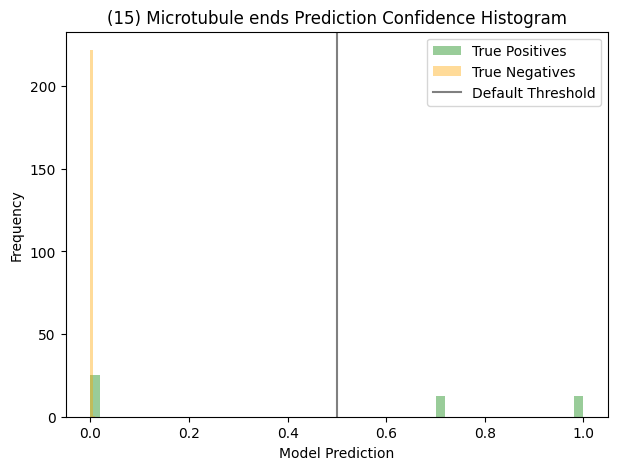

15 Microtubule ends - New Threshold: 0.5 | Improvement: 0.0 (0.0)


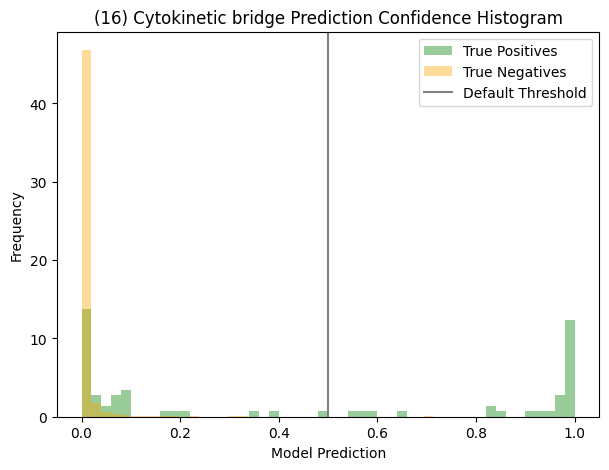

16 Cytokinetic bridge - New Threshold: 0.35871743486973945 | Improvement: 0.011090487541690397 (0.014479966743874037)


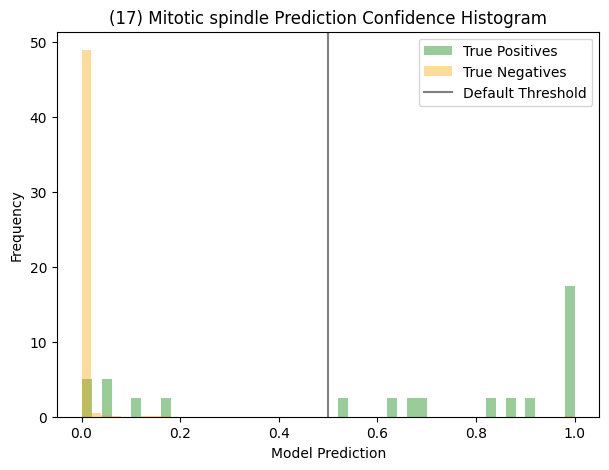

17 Mitotic spindle - New Threshold: 0.5130260521042084 | Improvement: 0.0074535552093507595 (0.009119511563477591)


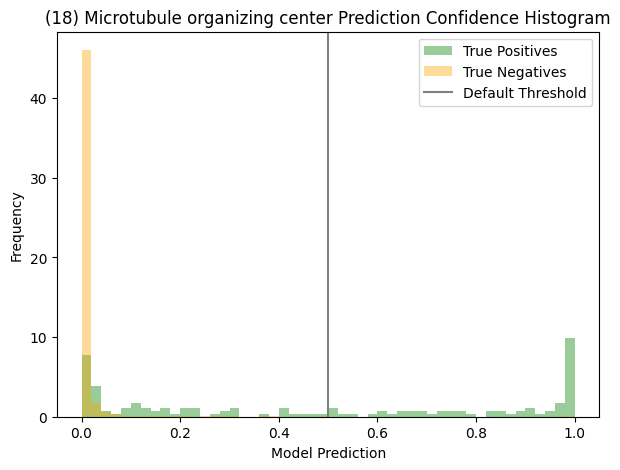

18 Microtubule organizing center - New Threshold: 0.3927855711422845 | Improvement: 0.009254787331668846 (0.011836514689144454)


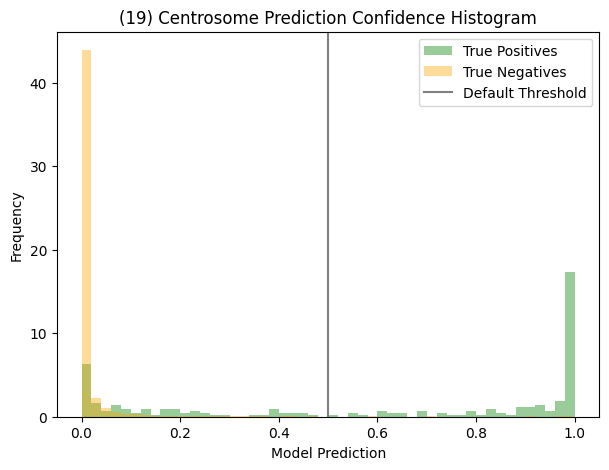

19 Centrosome - New Threshold: 0.3727454909819639 | Improvement: 0.003432532054770343 (0.004146131435118281)


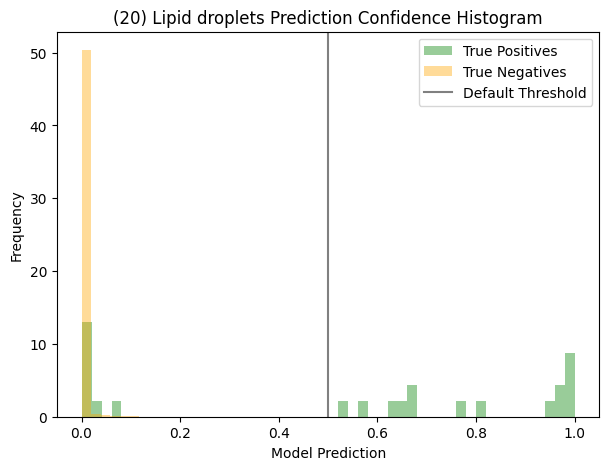

20 Lipid droplets - New Threshold: 0.5 | Improvement: 0.0 (0.0)


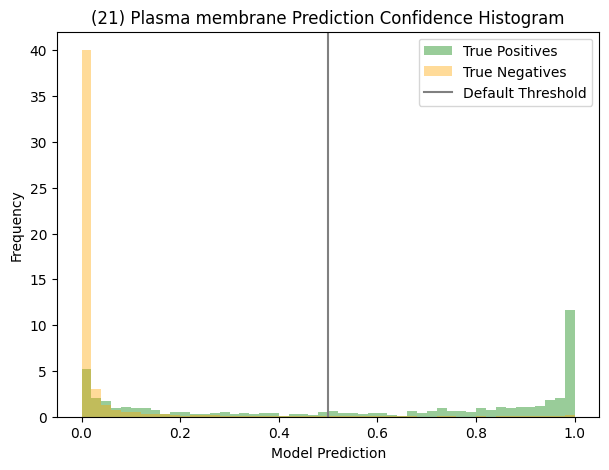

21 Plasma membrane - New Threshold: 0.47695390781563124 | Improvement: 0.0025601377805487546 (0.003124718535805384)


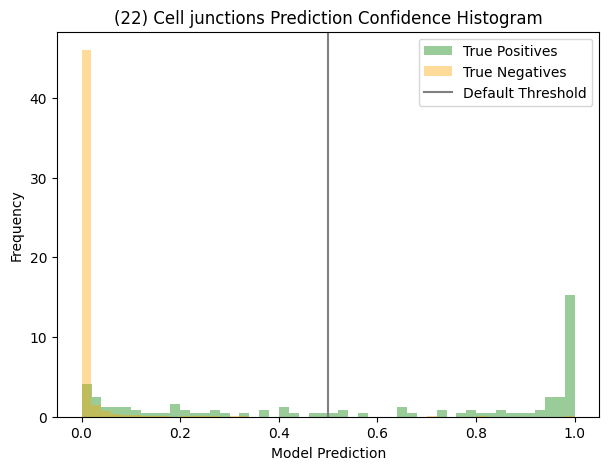

22 Cell junctions - New Threshold: 0.36472945891783565 | Improvement: 0.016401196362613613 (0.019812440282566405)


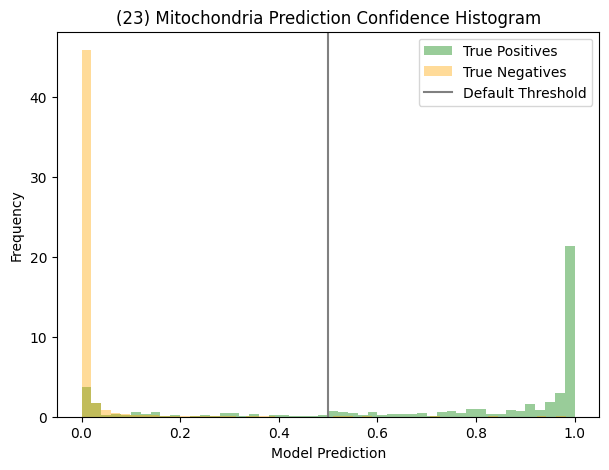

23 Mitochondria - New Threshold: 0.2785571142284569 | Improvement: 0.004361104588193054 (0.004832599960376387)


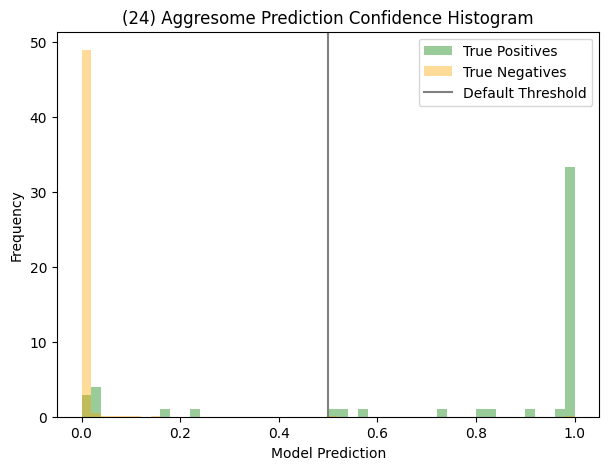

24 Aggresome - New Threshold: 0.5170340681362725 | Improvement: 0.005643901051203826 (0.006332387336387751)


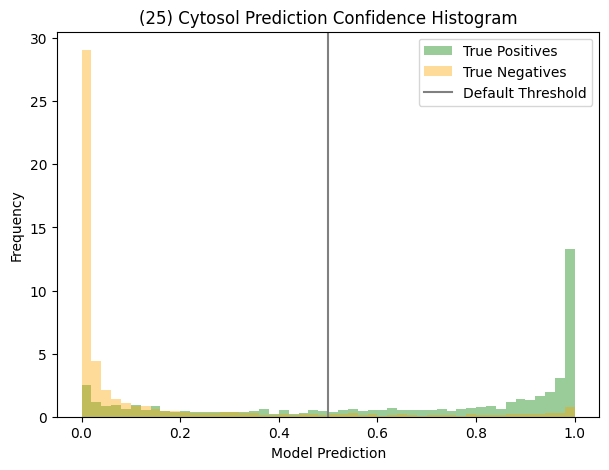

25 Cytosol - New Threshold: 0.3507014028056112 | Improvement: 0.004034757776940734 (0.005030177027738742)


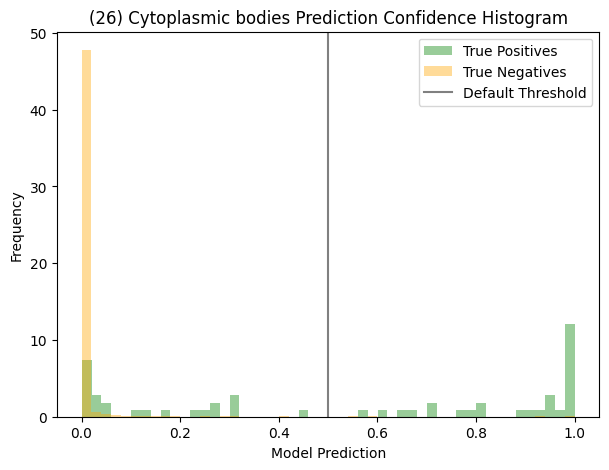

26 Cytoplasmic bodies - New Threshold: 0.5891783567134268 | Improvement: 0.012882946952059049 (0.016562812260528206)


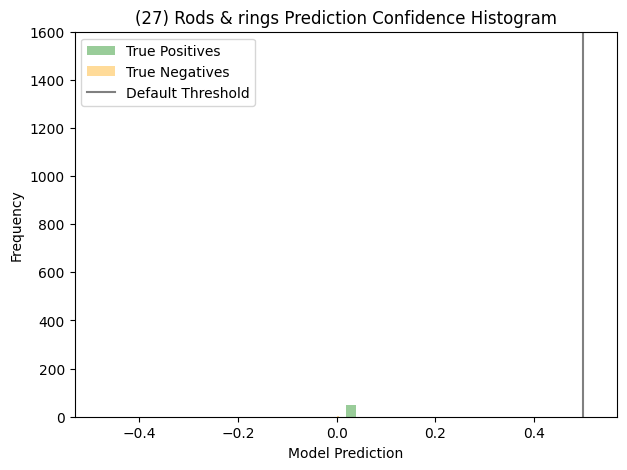

27 Rods & rings - New Threshold: 0.01603206412825651 | Improvement: 0.24994632314585336 (0.49994628284173803)


In [45]:
new_thresholds = np.zeros(28)
for idx in range(0,28):
    show_prediction_hist(idx)
    new_threshold, improvement, rel_improvement = find_threshold(idx)
    print(f"{idx} {labels_dict[idx]} - New Threshold: {new_threshold} | Improvement: {improvement} ({rel_improvement})")
    new_thresholds[idx] = new_threshold

In [49]:
score_1 = f1_score(actual, predictions > 0.5, average="macro")
score_2 = f1_score(actual, (predictions > 0.5).astype(int), average="macro")
print(score_1)
print(score_2)
np.save("thresholds.npy", new_thresholds)

0.7174099773762318
0.7174099773762318
